In [33]:
library(tidyverse)
library(tidyr)
library(rlang)
library(modules)
library(outliers)
library(car)
library(survival)
library(survminer)
library(e1071)    
setwd('C:/Users/iceca/Documents/Housing_Regression')
m <- modules::use("Helpers/Loading_Data.R")
m <- m$load.train
train <- m$no.outliers.data() %>% mutate(isTrain = 1)
labels <- train$SalePrice
test <- m$test.data() %>% select(-GarageArea)
train$SalePrice <- NULL
setdiff( names(test) , names(train))
dat <- rbind(train, test)


Warning message in library(modules):
"Packages loaded with 'library' may not be available inside a module. For loading packages in a module, use 'import' instead."Warning message in library(rlang):
"Packages loaded with 'library' may not be available inside a module. For loading packages in a module, use 'import' instead."

character(0)

In [34]:
names(dat)
is.na(dat$BldgType) %>% sum()


[1] "Id"            "Street"        "LotShape"      "LandContour"  
 [5] "LotConfig"     "LandSlope"     "BldgType"      "RoofStyle"    
 [9] "ExterQual"     "ExterCond"     "Heating"       "HeatingQC"    
[13] "CentralAir"    "PavedDrive"    "SaleCondition" "MSZoning"     
[17] "Utilities"     "MasVnrType"    "BsmtQual"      "BsmtCond"     
[21] "BsmtExposure"  "KitchenQual"   "GarageType"    "GarageFinish" 
[25] "GarageQual"    "GarageCond"    "MiscFeature"   "Neighborhood" 
[29] "Condition1"    "Condition2"    "HouseStyle"    "RoofMatl"     
[33] "Exterior1st"   "Exterior2nd"   "BsmtFinType1"  "BsmtFinType2" 
[37] "Functional"    "SaleType"      "MSSubClass"    "LotFrontage"  
[41] "LotArea"       "OverallQual"   "OverallCond"   "YearBuilt"    
[45] "YearRemodAdd"  "MasVnrArea"    "BsmtFinSF1"    "BsmtFinSF2"   
[49] "BsmtUnfSF"     "TotalBsmtSF"   "1stFlrSF"      "2ndFlrSF"     
[53] "LowQualFinSF"  "GrLivArea"     "BsmtFullBath"  "BsmtHalfBath" 
[57] "FullBath"      "HalfBath"      "BedroomAbvGr"  "KitchenAbvGr" 
[61] "TotRmsAbvGrd"  "Fireplaces"    "GarageYrBlt"   "GarageCars"   
[65] "WoodDeckSF"    "OpenPorchSF"   "EnclosedPorch" "3SsnPorch"    
[69] "ScreenPorch"   "PoolArea"      "MiscVal"       "MoSold"       
[73] "YrSold"        "isTrain"

[1] 0

In [35]:
#PORCH
#combine the 4 porch areas
train <- train %>% mutate(Porch = OpenPorchSF+EnclosedPorch+`3SsnPorch`+ScreenPorch) %>%
    select(-c(OpenPorchSF,EnclosedPorch,`3SsnPorch`,ScreenPorch))
test <- test %>% mutate(Porch = OpenPorchSF+EnclosedPorch+`3SsnPorch`+ScreenPorch) %>%
    select(-c(OpenPorchSF,EnclosedPorch,`3SsnPorch`,ScreenPorch))
dat <- dat %>% mutate(Porch = OpenPorchSF+EnclosedPorch+`3SsnPorch`+ScreenPorch) %>%
    select(-c(OpenPorchSF,EnclosedPorch,`3SsnPorch`,ScreenPorch))

In [36]:
#ROOFSTYLE
#Looking at the roofs, Hip and Gable seem normal, and hence desirable, everyhing else I will group into others
table(dat$RoofStyle)
norm.roofstyle = function(d) {
    d %>% mutate(NormalRoof = fct_collapse(d$RoofStyle, Normal=c("Gable", "Hip"), 
                                          Other = c("Flat", "Gambrel", "Mansard", "Shed")))
}
train <- norm.roofstyle(train)
test <- norm.roofstyle(test)
dat <- norm.roofstyle(dat)
table(dat$NormalRoof)



   Flat   Gable Gambrel     Hip Mansard    Shed 
     20    2309      22     545      11       5 


 Other Normal 
    58   2854 

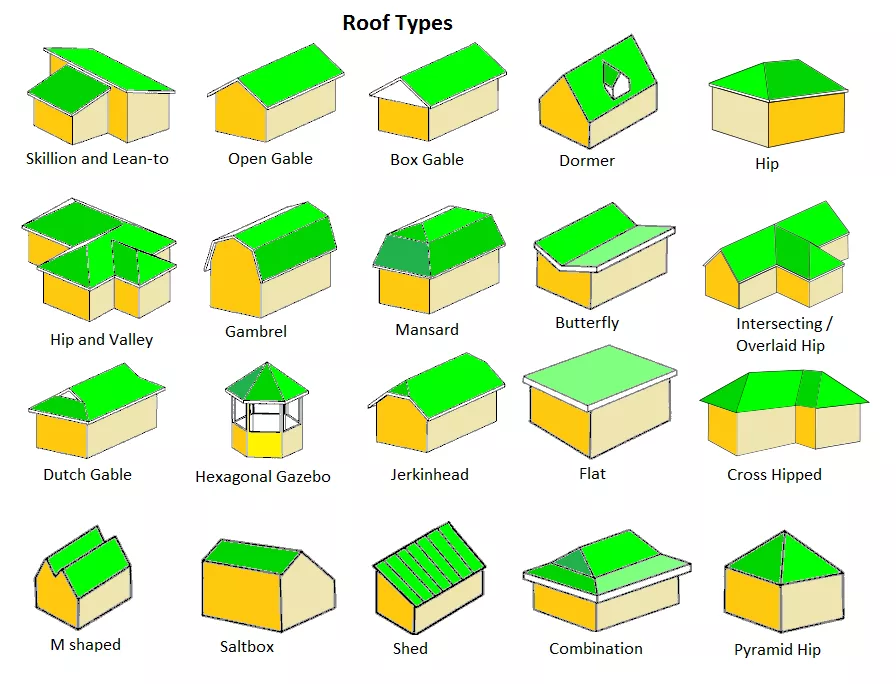

In [37]:
#HEATINGTYPE
#Looking at heating, GasA seems normal everything else seems abnormal
table(dat$Heating)
norm.heating = function(d) {
    d %>% mutate(NormalHeating = fct_collapse(d$Heating, Normal=c("GasA"), 
                                          Other = c("Floor", "GasW", "Grav", "OthW", "Wall")))
}
train <- norm.heating(train)
test <- norm.heating(test)
dat <- norm.heating(dat)
table(dat$NormalHeating)


Floor  GasA  GasW  Grav  OthW  Wall 
    1  2867    27     9     2     6 


 Other Normal 
    45   2867 

In [38]:
#UTILITIES AND FUNCTIONAL
#A home is normal if it has all utlities and has atmost minor functional problems
table(dat$Functional, dat$Utilities)
norm.utf = function(d) {
   d %>% mutate(NormalFunction = as.factor(ifelse(Utilities == "AllPub" & Functional %in% c("Typ","minor","moderate",
                                                                                 "Unknown"),
                                       "Normal", "Abnormal")))
}
train <- norm.utf(train)
test <- norm.utf(test)
dat <- norm.utf(dat)
table(dat$NormalFunction)                

          
           AllPub NoSeWa Unknown
  major        28      0       0
  minor       133      0       2
  moderate     35      0       0
  Sev           2      0       0
  Typ        2709      1       0
  Unknown       2      0       0


Abnormal   Normal 
      33     2879 

In [39]:
#SALECONDITION and SALETYPE
#A home is normal if it has all utlities and has atmost minor functional problems
table(dat$SaleCondition, dat$SaleType)
norm.sale = function(d) {
   d %>% mutate(NormalSale = as.factor(ifelse(SaleCondition == "Normal" & SaleType %in% c("New","WD","Unknown"),
                                       "Normal", "Abnormal")))
}    
train <- norm.sale(train)
test <- norm.sale(test)
dat <- norm.sale(dat)
table(dat$NormalSale)

         
           COD  Con ConLD ConLI ConLw  CWD  New  Oth Unknown   WD
  Abnorml   46    0     3     2     0    1    0    5       0  132
  AdjLand    0    0     0     0     0    0    0    0       0   12
  Alloca     0    0     0     0     0    0    0    0       0   24
  Family     2    0     1     2     1    1    0    1       0   38
  Normal    39    4    21     5     7   10    0    1       1 2312
  Partial    0    1     1     0     0    0  235    0       0    4


Abnormal   Normal 
     599     2313 

In [40]:
#BEDROOMS, KITCHENS AND BATHROOMS feature engineering
bkb.mutate = function(d) {
   d %>% mutate(AbvGrTotalBath = FullBath+HalfBath*0.5, 
                BsmtTotalBath = BsmtFullBath+BsmtHalfBath*0.5,
                TotalSQF = `1stFlrSF` + `2ndFlrSF`, 
                BedRoomsPerSQFAbvGr = BedroomAbvGr/GrLivArea, 
                KitchensPerBedroom = (KitchenAbvGr+1)/max(0.1,BedroomAbvGr), #add one cause of ground floor 
                BathPerBedRoom = AbvGrTotalBath/max(0.1,BedroomAbvGr),
                ExtraRoom = TotRmsAbvGrd-BedroomAbvGr
                )
}
train <- bkb.mutate(train)
test <- bkb.mutate(test)
dat <- bkb.mutate(dat)

In [41]:
#ORDERING THE FACTORS
pvd = function(d) {
    d %>% mutate(PavedDrive = ordered(d$PavedDrive, levels=c("N", "P", "Y")))
}
train <- pvd(train)
test <- pvd(test)
dat <- pvd(dat)

func = function(d) {
    d %>% mutate(Functional = ordered(d$Functional, levels=c('Sev','major','Unknown','minor','moderate','Typ')))
}
train <- func(train)
test <- func(test)
dat <- func(dat)

util = function(d) {
    d %>% mutate(Utilities = ordered(d$Utilities, levels=c('ELO','NoSeWa','NoSewr','Unknown','AllPub')))
}
train <- util(train)
test <- util(test)
dat <- util(dat)

bldtyp = function(d) {
    d %>% mutate(BldgType = ordered(d$BldgType, levels=c(
    'Twnhs' ,'TwnhsE','Duplex','2fmCon','1Fam'
    )))
}
train <- bldtyp(train)
test <- bldtyp(test)
dat <- bldtyp(dat)

BsmtExp = function(d) {
    d %>% mutate(BsmtExposure = ordered(d$BsmtExposure, levels=c(
    'Unknown', 'No', 'Mn', 'Av', 'Gd')))
}
train <- BsmtExp(train)
test <- BsmtExp(test)
dat <- BsmtExp(dat)

LotShp = function(d) {
    d %>% mutate(LotShape = ordered(d$LotShape, levels=c(
    'IR3', 'IR2', 'IR1', 'Reg'
    )))
}
train <- LotShp(train)
test <- LotShp(test)
dat <- LotShp(dat)

LotSlp = function(d) {
    d %>% mutate(LandSlope = ordered(d$LandSlope, levels=c(
    'Sev', 'Mod', 'Gtl' )))
}

train <- LotSlp(train)
test <- LotSlp(test)
dat <- LotSlp(dat)

levels(dat$LandSlope)

[1] "Sev" "Mod" "Gtl"

In [42]:
#HOUSINGSTYLE
#Housing style contains several peices of useful information, how many levels,
    #whether those levels are unfinished or finished, if the home has split levels, 
    #and home have splitfoyer
HsSty = function(d) {
    d %>% mutate(
        SplitFoyer = (HouseStyle=="SFoyer"), 
        SplitLevel = (HouseStyle=="SLvl"), 
        Unfinished = (HouseStyle %in% c("1.5Unf", "2.5Unf")),
        NumberLevel = as.numeric(ifelse(!is.na(str_extract(HouseStyle, "(\\d+\\.?\\d*)" )) , 
                            str_extract(HouseStyle, "(\\d+\\.?\\d*)"),
                             2 #both syoer and slevels have 2 levels each
                            )) ) %>% select(-HouseStyle)
}

train <- HsSty(train)
test <- HsSty(test)
dat <- HsSty(dat)

table(dat$NumberLevel)



   1  1.5    2  2.5 
1470  333 1077   32 

In [43]:
#YEARBLT,LOTAREA, TOTALAREA relative to neighborhood
#Perhaps new homes in "old" neighborhoods are desirable because the community is already settled

#see how statistics are calculated based off of training test
stats.by.neighboorhood <- train %>% group_by(Neighborhood) %>% summarize(
    year = mean(YearRemodAdd), lotarea =mean(LotArea), totalsqf = mean(TotalSQF))

find.year <- function(v) {
    sapply(v, function(x) {stats.by.neighboorhood %>% filter(Neighborhood == x) %>% .$ year})
}
find.lotarea <- function(v) {
    sapply(v, function(x) {stats.by.neighboorhood %>% filter(Neighborhood == x) %>% .$ lotarea})
}
find.totalsqf <- function(v) {
    sapply(v, function(x) {stats.by.neighboorhood %>% filter(Neighborhood == x) %>% .$ totalsqf})
}

rel.neighborhood <- function(d) {
    d %>% mutate(YearNbrhd = YearRemodAdd - find.year(Neighborhood), 
                LotAreaNbrhd = LotArea - find.lotarea(Neighborhood), 
                TotalSqfNbrHd = TotalSQF - find.totalsqf(Neighborhood))
}

train <- rel.neighborhood(train)
test <- rel.neighborhood(test)
dat <- rel.neighborhood(dat)



`summarise()` ungrouping output (override with `.groups` argument)


In [44]:
#QUALITY and CONDITION
#Create a new feature quality*condition, this will measure the interaction between the quality and condition. 
#I also think most people confuse quality and condition, hence 
#I will make a feature for some feature, max(quality,condition) as I don't want to explode the number of features

order.qual.cond.NoNA <- function(x) {
    factor(x , levels=c("Po","Fa","TA","Gd","Ex"), ordered=TRUE)
}
order.qual.cond.YesNA <- function(x) {
    factor(x , levels=c("Unknown","Po","Fa","TA","Gd","Ex"), ordered=TRUE)
}
order.qual.cond <- function(d) {
    d %>% mutate(
    BsmtQual =        ordered(d$BsmtQual,c('Unknown', 'normal','great')  ),
    BsmtCond =        order.qual.cond.YesNA(d$BsmtCond), 
    GarageQual =      ordered(d$GarageQual,c('Unknown', 'bad','fine')  ), 
    GarageCond =      ordered(d$GarageCond,c('Unknown', 'bad','fine')  ),  
    ExterCond =       order.qual.cond.NoNA(d$ExterCond)    ,
    ExterQual =       order.qual.cond.NoNA(d$ExterQual),
    KitchenQual =     order.qual.cond.YesNA(d$KitchenQual),
        
    BsmtQualCond      =     as.numeric(d$BsmtQual)*  as.numeric(d$BsmtCond),
    ExterQualCond     =     as.numeric(d$ExterQual)* as.numeric(d$ExterCond),    
    OverQualCond      =     as.numeric(d$OverallQual)*as.numeric(d$OverallCond), 
    BsmtQualCondMax   =pmax(as.numeric(d$BsmtQual),  as.numeric(d$BsmtCond)),
    GarageQualCondMax =pmax(as.numeric(d$GarageQual),as.numeric(d$GarageCond)),
    ExterQualCondMax  =pmax(as.numeric(d$ExterQual), as.numeric(d$ExterCond)) 
    )
}
train <- order.qual.cond(train)
test <- order.qual.cond(test)
dat <- order.qual.cond(dat)

In [45]:
train$isTrain=NULL
test$isTrain=NULL
dat$isTrain=NULL

#save a featurengineered version of the raw data
save(train, file = "Data/RDAs/RawFeatEngTrain.rda")
save(test, file = "Data/RDAs/RawFeatEngTest.rda")
save(dat , file = "Data/RDAs/RawFeatEngData.rda")


#save a normalized featurengineered version of the data
scale.dat <- function(d) {
    d %>% select(-Id) %>% mutate_if(is.numeric, scale) %>% mutate(Id=d$Id) %>% arrange(Id)
}
tr <- scale.dat(train) 
tst <- scale.dat(train) 
dt <- scale.dat(dat)
save(tr , 
     file = "Data/RDAs/NormFeatEngTrain.rda")
save(tst   ,
     file = "Data/RDAs/NormFeatEngTest.rda")
save(dt    ,
     file = "Data/RDAs/NormFeatEngData.rda")

#save a skewed-features-log-transformed + normalized version of the data
log.transform <- function(v){sapply(v , 
                       function(x){
                           log2(max(0.1, x)) }
                      )
               }
skews.data <- sapply(train %>% select_if(is.numeric), skewness)
skews <- skews.data[skews.data>1.0 & !is.na(skews.data)] %>% names() #select columns with more then 1.0 in skewness
skews <- skews[ !(skews %in% c( 'GarageQualCondMax','BsmtQualCondMax', 'GarageQualCondMax', 'Id'))]
log.transform.data <- function(d) {
    d  %>% mutate_at(skews, log.transform) 
}

tr <- scale.dat(log.transform.data( train))
tst <- scale.dat(log.transform.data( test))
dt <- scale.dat(log.transform.data( dat))
save(tr  , 
     file = "Data/RDAs/FeatEngTrain.rda")
save(tst  ,
     file = "Data/RDAs/FeatEngTest.rda")
save(dt   ,
     file = "Data/RDAs/FeatEngData.rda")

In [46]:
#save a smaller version of the data, removing features that have little effect based on exploration module

drop.cols = c('LandContour' , 'MSSubClass', 'LandSlope','BsmtExposure','YearBuilt' ,
                 'BsmtFullBath', 'BsmtHalfBath','ExterCond','ExterQualCondMax','GarageYrBlt', 'Fireplaces',
                'KitchenAbvGr', 'KitchensPerBedroom', 'HeatingQC', 'PoolArea','Porch' ,'RoofMatl', 'RoofStyle',
                'WoodDeckSF', 'SplitFoyer', 'SplitLevel', 'Street','YrSold','GarageQualCondMax')

tr <- tr %>% select(-drop.cols)
tst <- tst %>% select(-drop.cols)
dt <- dt %>% select(-drop.cols)
save(tr  , 
     file = "Data/RDAs/TrimFeatEngTrain.rda")
save(tst  ,
     file = "Data/RDAs/TrimFeatEngTest.rda")
save(dt   ,
     file = "Data/RDAs/TrimFeatEngData.rda")